In [2]:
# 可视化常规导入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
INPUT_DIR = 'C:/ZhangLI/Codes/DataSet/m5-forecasting-accuracy'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

# 数据可视化
## 简单可视化
1. plot

<AxesSubplot:title={'center':'FOODS_3_090_CA_3 sales by actual sale dates'}, xlabel='date'>

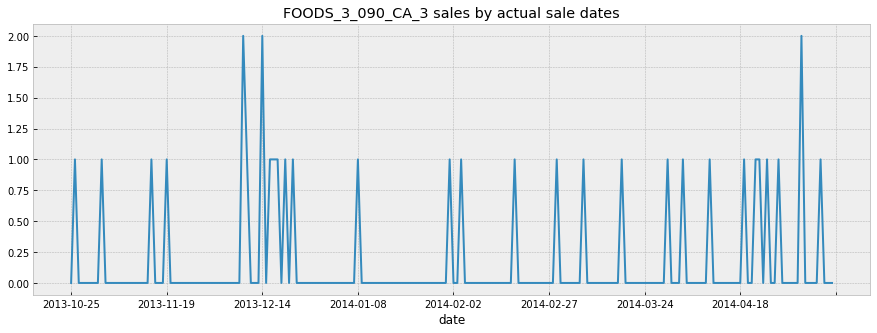

In [4]:
# set_index/ T / reset_index() / rename / merge 
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
sales_train_val_new = sales_train_val.set_index('id')[d_cols].T.reset_index().rename(columns={'index':'d'}).merge(calendar, how='left', validate='1:1').set_index('date')
sales_train_val_new['HOBBIES_1_002_CA_1_validation'][1000:1200].plot(figsize=(15, 5), color=next(color_cycle), title='FOODS_3_090_CA_3 sales by actual sale dates')

# 平稳性检验 Stability test 
## 时序图/可视化检验[]
## 分段统计均值和方差
1. 直接将序列前后拆分成2个序列，分别计算这2个序列的均值、方差，对比看是否差异明显。
## 可视化统计特征 ACF-自相关系数 PACF-偏自相关系数
1. 对于平稳的时间序列，自相关系数往往会迅速退化到零（滞后期越短相关性越高，滞后期为0时，相关性为1）；而对于非平稳的数据，退化会发生得更慢，或存在先减后增或者周期性的波动等变动。
X = [2,3,4,3,8,7]
A = [2,3,4,3,8]
B = [3,4,3,8,7]
\bar{X} = \sum{X}/6
s^2(X) = \sum{(X_i-\bar{X})^2}
r(1) = \sum{(A-\bar{X})(B-\bar{X})}
ACF(1) = r(1)/ s^2(X)

## 假设检验的方法 单位根 DF-test ADF-test PP-test DF-gls kpss
1. ADF检验 
> * 原假设 （存在单位根，时间序列是非平稳的）
> * 备择假设 （不存在单位根，时间序列是平稳的--不含截距项和趋势项平稳/含截距项平稳/含截距项和趋势平稳）

The mean of data is: 0.14, The var of data is: 0.14
The mean of data is: 0.37, The var of data is: 0.38
The mean of data is: 0.33, The var of data is: 0.44
   Augmented Dickey-Fuller Results   
Test Statistic                 -8.140
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -8.267
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.98 (1%), -3.42 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.320
P-value 

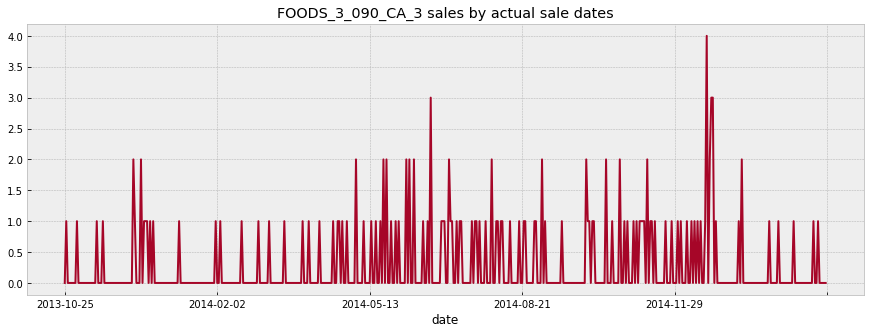

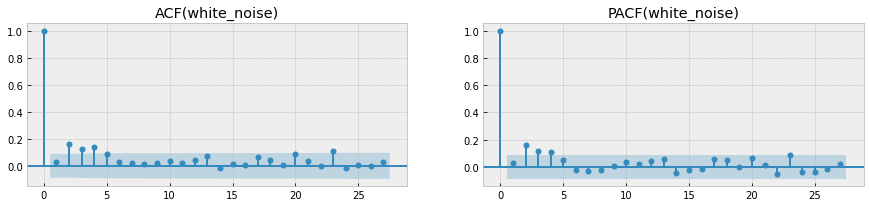

In [27]:
# 平稳性检验 Stability test 
data = sales_train_val_new['HOBBIES_1_002_CA_1_validation'][1000:1500]
# 1. 可视化数据
data.plot(figsize=(15, 5), color=next(color_cycle), title='FOODS_3_090_CA_3 sales by actual sale dates')
# 2. 可视化统计特征
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# subplots(1,2)使用ax[0] ax[1]  subplots(2,2)使用ax[0][0] ax[0][1]两位 
fig, ax = plt.subplots(1, 2, figsize=(15,3))
fig.subplots_adjust(hspace=0.5)


plot_acf(data.values, ax=ax[0])
ax[0].set_title('ACF(white_noise)')
plot_pacf(data, ax=ax[1])
ax[1].set_title('PACF(white_noise)')

# 3. 简单的统计方法 统计均值和方差
# 设计一个函数，分段取几个值
k = 3
n = int(len(data) / 3)
for i in range(k):
    # print(data[n*i:n*(i+1)])
    avg = np.mean(data[i*n:n*(i+1)])
    var = np.var(data[i*n:n*(i+1)])
    print(f'The mean of data is: {round(avg,2)}, The var of data is: {round(var,2)}',)

# 4. 假设检验
# 4.1 ADF
# arch包中ADF检验可指定trend为
# 'n'（不含截距项和时间趋势项）
# 'c'（含截距项）
# 'ct'（含截距项和时间趋势项）
# 'ctt'（含截距项和时间趋势项和二次型时间趋势项）
from arch.unitroot import ADF
adf = ADF(data)
# print(adf.pvalue)
print(adf.summary().as_text())

# 默认为 'c'
adf = ADF(data, trend='ct')
print(adf.summary().as_text())

# 4.2 PP
import numpy as np
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(data)
print(pp.summary().as_text())

pp = PhillipsPerron(data, trend = 'ct')
print(pp.summary().as_text())

# 4.3 DFGLS
import numpy as np
from arch.unitroot import DFGLS

dfgls = DFGLS(data)
print(dfgls.summary().as_text())

# 不指定trend情况下不能拒绝原假设，非平稳；指定trend='ct'时p值小于0.05，拒绝原假设，带截距项和时间趋势平稳。
dfgls = DFGLS(data, trend = 'ct')
print(dfgls.summary().as_text())

# 4.4 KPSS
# 原假设：序列不存在单位根（时间序列是平稳的或趋势平稳的）
# 备择假设：序列存在单位根（时间序列是非平稳的）
import numpy as np
from arch.unitroot import KPSS

kpss = KPSS(data)
print(kpss.summary().as_text())

kpss = KPSS(data, trend = 'ct')
print(kpss.summary().as_text())


In [15]:
data.isna().sum()

0